In [1]:
import jax.numpy as np
import numpy as onp
from jax import random, grad, jit, vmap
from functools import partial
key = random.PRNGKey(0)
from jax.experimental import optimizers
from NODE_ICNN_CANN_MF_fns import *
import matplotlib.pyplot as plt
import pickle
from jax.config import config
import pandas as pd
config.update("jax_enable_x64", True)
plt.rcParams.update({'font.size': 12})

import pandas as pd
from sklearn.metrics import r2_score

/opt/homebrew/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/opt/homebrew/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


# Train NODE, CANN, ICNN, MFNN, directly against rubber stress data

Train directly against the stress data from the three rubber datasets.
Note. I wanted to do these four different schemes. the last one I wanted to do was this MF scheme where I would combine a CANN with a NODE but that doesnt seem necessary in that the CANN and the NODE alone can do just fine for rubber data. So at least for rubber doesnt seem necessary. 

In [2]:
class CANN_model():
    def __init__(self, params_I1, params_I2,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.normalization = normalization
    # Psi1
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        return CANN_dpsidInorm(I1norm,self.params_I1)[:,0]/normalization[0]
    # Psi2
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        return CANN_dpsidInorm(I2norm,self.params_I2)[:,0]/normalization[1]

# play with ICNN a bit, how do we get that one to work
class ICNN_model():
    def __init__(self, params_I1, params_I2,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.normalization = normalization
    # Psi1
    # note: for ICNN the prediction is the function not the gradient
    # but the P11_UT, P11_ET, etc expects the model to output the derivative
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        f1 = lambda x: icnn_forwardpass(x, self.params_I1)[0]
        #normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
        df1 = grad(f1)
        return vmap(df1)(I1norm[:,None])[:,0]/self.normalization[0]
    # Psi2
    # note: for ICNN the prediction is the function not the gradient
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        f2 = lambda x: icnn_forwardpass(x, self.params_I2)[0]
        #normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
        df2 = grad(f2)
        return vmap(df2)(I2norm[:,None])[:,0]/self.normalization[1]
        
## NODE model outputs normalized strain energy given normalized invariants
class NODE_model():
    def __init__(self, params_I1, params_I2):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        return NODE_posb_vmap(I1norm, self.params_I1)
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        return NODE_posb_vmap(I2norm, self.params_I2)

def plotstresses(x_gt,y_gt,x_pr,y_pr):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    labels = ['UT', 'ET', 'PS']
    for axi, x_gti, y_gti, x_pri, y_pri, label in zip(ax, x_gt, y_gt, x_pr, y_pr, labels):
        axi.plot(x_gti, y_gti, 'k.')
        axi.plot(x_pri, y_pri)
        axi.set_title(label)
        axi.set_xlabel(r'Stretch $\lambda [-]$')
        axi.set_ylabel(r'Nominal stress $P_{11} [MPa]$')
    return fig, ax

In [3]:
def P11_UT(lamb, model, normalization):
    I1_factor = normalization[0]
    I2_factor = normalization[1]
    Psi1_factor = normalization[2]
    Psi2_factor = normalization[3]
    I1 = lamb**2 + 2/lamb
    I2 = 2*lamb + 1/lamb**2
    I1norm = (I1-3)/I1_factor
    I2norm = (I2-3)/I2_factor
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    return 2*(Psi1 + Psi2/lamb)*(lamb-1/lamb**2)
def P11_ET(lamb, model, normalization):
    I1_factor = normalization[0]
    I2_factor = normalization[1]
    Psi1_factor = normalization[2]
    Psi2_factor = normalization[3]
    I1 = 2*lamb**2 + 1/lamb**4
    I2 = lamb**4 + 2/lamb**2
    I1norm = (I1-3)/I1_factor
    I2norm = (I2-3)/I2_factor
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    return 2*(Psi1 + Psi2*lamb**2)*(lamb-1/lamb**5)
def P11_PS(lamb, model, normalization):
    I1_factor = normalization[0]
    I2_factor = normalization[1]
    Psi1_factor = normalization[2]
    Psi2_factor = normalization[3]
    I1 =  lamb**2 + 1/lamb**2 + 1
    I2 =  lamb**2 + 1/lamb**2 + 1
    I1norm = (I1-3)/I1_factor
    I2norm = (I2-3)/I2_factor
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    return 2*(Psi1+Psi2)*(lamb-1/lamb**3)

In [4]:
## Eval invariants for the three types of deformation
def evalI1_UT(lam):
    return lam**2 + (2/lam)
def evalI2_UT(lam):
    return 2*lam + (1/lam**2)

def evalI1_ET(lam):
    return 2*lam**2 +1/lam**4
def evalI2_ET(lam):
    return lam**4 + 2/lam**2

def evalI1_PS(lam):
    return lam**2 + 1/lam**2 + 1
def evalI2_PS(lam):
    return lam**2 + 1/lam**2 + 1

In [5]:
# read the data
UTdata = pd.read_csv('Data/UT20.csv')
ETdata = pd.read_csv('Data/ET20.csv')
PSdata = pd.read_csv('Data/PS20.csv')
# stack into single array 
P11_data = np.hstack([UTdata['P11'].to_numpy(),ETdata['P11'].to_numpy(),PSdata['P11'].to_numpy()])
F11_data = np.hstack([UTdata['F11'].to_numpy(),ETdata['F11'].to_numpy(),PSdata['F11'].to_numpy()])
# indices for the three data sets
indET = len(UTdata['P11'])
indPS = indET + len(ETdata['P11'])

In [6]:
I1_factor = 30
Psi1_factor = 0.3
I2_factor = 250
Psi2_factor = 0.001
normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]

@partial(jit, static_argnums=(2,))
def loss_P11_all(params, F11_data, mdlnumber):
    lamUT = F11_data[0:indET]
    lamET = F11_data[indET:indPS]
    lamPS = F11_data[indPS:]
    params_I1 = params[0]
    params_I2 = params[1]
    if mdlnumber == 1:
        model = CANN_model(params_I1,params_I2,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(params_I1,params_I2,normalization)
    else:
        model = NODE_model(params_I1,params_I2)
    P11UT_pr = P11_UT(lamUT, model, normalization)
    P11ET_pr = P11_ET(lamET, model, normalization)
    P11PS_pr = P11_PS(lamPS, model, normalization)    
    return np.mean((P11UT_pr-P11_data[0:indET])**2)+np.mean((P11ET_pr-P11_data[indET:indPS])**2)+np.mean((P11PS_pr-P11_data[indPS:])**2)

@partial(jit, static_argnums=(2,))
def loss_P11_UT(params, F11_data, mdlnumber):
    lamUT = F11_data[0:indET]
    params_I1 = params[0]
    params_I2 = params[1]
    if mdlnumber == 1:
        model = CANN_model(params_I1,params_I2,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(params_I1,params_I2,normalization)
    else:
        model = NODE_model(params_I1,params_I2)
    P11UT_pr = P11_UT(lamUT, model, normalization)
    return np.mean((P11UT_pr-P11_data[0:indET])**2)

@partial(jit, static_argnums=(2,))
def loss_P11_ET(params, F11_data, mdlnumber):
    lamET = F11_data[indET:indPS]
    params_I1 = params[0]
    params_I2 = params[1]
    if mdlnumber == 1:
        model = CANN_model(params_I1,params_I2,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(params_I1,params_I2,normalization)
    else:
        model = NODE_model(params_I1,params_I2)
    P11ET_pr = P11_ET(lamET, model, normalization)
    return np.mean((P11ET_pr-P11_data[indET:indPS])**2)

@partial(jit, static_argnums=(2,))
def loss_P11_PS(params, F11_data, mdlnumber):
    lamPS = F11_data[indPS:]
    params_I1 = params[0]
    params_I2 = params[1]
    if mdlnumber == 1:
        model = CANN_model(params_I1,params_I2,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(params_I1,params_I2,normalization)
    else:
        model = NODE_model(params_I1,params_I2)
    P11PS_pr = P11_PS(lamPS, model, normalization)    
    return np.mean((P11PS_pr-P11_data[indPS:])**2)


@partial(jit, static_argnums=(0,1,))
def step_jp(loss, mdlnumber, i, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, mdlnumber)
    return opt_update(i, g, opt_state)

def train_jp(loss, mdlnumber, X, opt_state, key, nIter = 10000, print_freq = 1000):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        opt_state = step_jp(loss, mdlnumber, it, opt_state, X)         
        if (it+1)% print_freq == 0 or it==0 or it==nIter:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, mdlnumber)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss


n_params_cann = 12
n_params_icnn = 4 + 12*2 + 3*2 = 34 #Use layers= [1,4,3,1] for icnn #actually 32?
n_params_node = 5 + 25 + 5 = 35 #Use layers = [1,5,5,1] 


What if we use [1,2,3,1] for node? Then use [1,4,1] for icnn
n_params_cann = 12
n_params_node = 2+6+3 = 11
n_params_icnn = 4+2*4 = 12

In [7]:
def init_node(key, layers = [1,5,5,1]):
    params_I1 = init_params_posb(layers, key) 
    params_I2 = init_params_posb(layers, key)
    return [params_I1,params_I2]

def init_icnn(key, layers = [1,3,4,1]):
    params_I1 = init_params_icnn(layers, key)
    params_I2 = init_params_icnn(layers, key)
    return [params_I1,params_I2]

def init_cann(key, layers = None):
    params_I1 = init_params_cann(key)
    params_I2 = init_params_cann(key)
    return [params_I1,params_I2]

def n_params_node(layers=[1,5,5,1]):
    n = 0
    for i in range(len(layers)-1):
        n+= layers[i]*layers[i+1]
    return n*2

def n_params_icnn(layers=[1,4,3,1]):
    n = 0
    n += layers[0]*layers[1] + layers[1]
    for i in range(1,len(layers)-1):
        n+= layers[i]*layers[i+1] #Wz
        n+= layers[0]*layers[i+1] #Wy
        n+= layers[i+1] #b
    return n*2

def opt_arch_node(n): # return the "sorta" best architecture given # of parameters
    archs = [[1,2,2,1],[1,3,3,1],[1,4,4,1],[1,5,5,1],[1,4,4,4,1],[1,5,5,5,1],[1,6,6,6,1],[1,6,6,6,6,1]]
    m = onp.array([16, 30, 48, 70, 80, 120, 168, 240])

    idx = (onp.abs(m-n)).argmin()
    nominal_arch = archs[idx]
    closest_arch = archs[idx]
    closest_m = m[idx]

    diff = onp.abs(closest_m-n)
    for i in range(len(nominal_arch)-2):
        for j in [-1,0,1]:
            arch = onp.copy(nominal_arch)
            arch[i+1]+= j
            m = n_params_node(arch)
            if np.abs(m-n)<diff:
                diff = onp.abs(m-n)
                closest_arch = onp.copy(arch)
                closest_m = m
    return closest_m, closest_arch


def opt_arch_icnn(n): # return the "sorta" best architecture given # of parameters
    archs = [[1,2,1],[1,3,1],[1,4,1],[1,2,2,1],[1,3,3,1],[1,4,4,1],[1,5,5,1],[1,4,4,4,1],[1,5,5,5,1],[1,6,6,6,1],[1,6,6,6,6,1]]
    m = onp.array([16, 22, 28, 32, 52, 76, 104, 124, 174, 232, 328])

    idx = (onp.abs(m-n)).argmin()
    nominal_arch = archs[idx]
    closest_arch = archs[idx]
    closest_m = m[idx]

    diff = onp.abs(closest_m-n)
    for i in range(len(nominal_arch)-2):
        for j in [-1,0,1]:
            arch = onp.copy(nominal_arch)
            arch[i+1]+= j
            m = n_params_icnn(arch)
            if np.abs(m-n)<diff:
                diff = onp.abs(m-n)
                closest_arch = onp.copy(arch)
                closest_m = m
    return closest_m, closest_arch

## 50 runs

### All

In [8]:
lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])
r2_list = []
mae_list = []
for i in range(50): #50 runs for every architecture
    key, subkey = random.split(key)
    params = init_cann(key)

    opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
    opt_state = opt_init(params)
    params, train_loss, val_loss = train_jp(loss_P11_all, 1, F11_data, opt_state, key, nIter = 100000, print_freq=1000000)

    model = CANN_model(params[0], params[1], normalization)

    lambdas     = [lamUT_vec,       lamET_vec,      lamPS_vec       ]
    P11_gt_list = [UTdata['P11'],   ETdata['P11'],  PSdata['P11']   ]
    P11funs     = [P11_UT,          P11_ET,         P11_PS          ]

    r2 = []
    mae = []
    for lam, P11_gt, P11fun in zip(lambdas, P11_gt_list, P11funs):
        P11 = P11fun(lam, model, normalization)
        r2i = r2_score(P11_gt, P11)
        r2i = np.clip(r2i, a_min=0.0, a_max=1.0)
        r2.append(r2i)

        maei = onp.mean(onp.abs(P11_gt-P11))
        mae.append(maei)
    # r2 = np.mean(np.array(r2))
    print(*mae)
    r2_list.append(r2)
    mae_list.append(mae)
cann_r2 = np.array(r2_list)
cann_mae = np.array(mae_list)

# cann_r2 = np.expand_dims(cann_r2,axis=1)
# cann_mae = np.expand_dims(cann_mae,axis=1)
with open('savednet/CANN_r2_efficiency_ALL.npy', 'wb') as f:
    pickle.dump([[24], cann_r2], f)

with open('savednet/CANN_mae_efficiency_ALL.npy', 'wb') as f:
    pickle.dump([[24], cann_mae], f)

it 1, train loss = 8.404907e+00
0.05193170387154177 0.052095787796723664 0.025198639797350313
it 1, train loss = 1.326932e+06
0.045904429565109275 0.05320992831410337 0.025581879337100575
it 1, train loss = 6.712172e+00
0.05193175685103336 0.05209580498840594 0.02519861352083013
it 1, train loss = 7.790573e+00
0.0519347446486862 0.052095797240054496 0.025197279820158076
it 1, train loss = 3.801197e+00
0.045654749100684386 0.05320483279728786 0.0255860475354747
it 1, train loss = 7.855335e+00
0.046947120848907994 0.053178546173881465 0.02564241808621302
it 1, train loss = 1.653415e+02
0.05193167458927169 0.052095843857941734 0.025198638166204785
it 1, train loss = 5.326038e+00
0.04769043587890498 0.054257354609790025 0.024956621718624235
it 1, train loss = 1.198337e+13
0.05441523382011651 0.05926188021826067 0.03356219927057632
it 1, train loss = 5.524966e+06
0.04549461034216314 0.05320417358443523 0.02558577165333445
it 1, train loss = 1.439198e+05
0.047751964504588906 0.05322673930648

In [51]:
lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])
np_list = []
r2_list_global = []
mae_list_global = []
for n in range(10,50):
    n_params, layers = opt_arch_node(n)
    if n_params in np_list:
        continue
    print(n_params, layers)
    np_list.append(n_params)

    r2_list_arch = []
    mae_list_arch = []
    for i in range(50): #50 runs for every architecture
        key, subkey = random.split(key)
        params = init_node(key, layers)

        # Make sure you are starting at a good place
        loss = loss_P11_all(params, F11_data, 3)
        while loss>3.0:
            key, subkey = random.split(key)
            params = init_node(key, layers)
            loss = loss_P11_all(params, F11_data, 3)

        opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 2.e-4
        opt_state = opt_init(params)
        params, train_loss, val_loss = train_jp(loss_P11_all, 3, F11_data, opt_state, key, nIter = 100000, print_freq=1000000)

        model = NODE_model(params[0], params[1])

        lambdas     = [lamUT_vec,       lamET_vec,      lamPS_vec       ]
        P11_gt_list = [UTdata['P11'],   ETdata['P11'],  PSdata['P11']   ]
        P11funs     = [P11_UT,          P11_ET,         P11_PS          ]

        r2 = []
        mae = []
        for lam, P11_gt, P11fun in zip(lambdas, P11_gt_list, P11funs):
            P11 = P11fun(lam, model, normalization)
            r2i = r2_score(P11_gt, P11)
            r2i = np.clip(r2i, a_min=0.0, a_max=1.0)
            r2.append(r2i)

            maei = onp.mean(onp.abs(P11_gt-P11))
            mae.append(maei)
        # r2 = np.mean(np.array(r2))
        # print(*r2)
        print(*mae)
        r2_list_arch.append(r2)
        mae_list_arch.append(mae)
    r2_list_global.append(r2_list_arch)
    mae_list_global.append(mae_list_arch)
node_r2 = np.array(r2_list_global)
node_mae = np.array(mae_list_global)

# node_r2 = np.expand_dims(node_r2,axis=2)
# node_mae = np.expand_dims(node_mae,axis=2)
with open('savednet/NODE_r2_efficiency_ALL.npy', 'wb') as f:
    pickle.dump([np_list, node_r2], f)

with open('savednet/NODE_mae_efficiency_ALL.npy', 'wb') as f:
    pickle.dump([np_list, node_mae], f)

10 [1 1 2 1]
it 1, train loss = 2.659942e+00
0.07873514637541149 0.04594043029643912 0.027139178557338946
it 1, train loss = 7.676506e-01
0.07886734892642665 0.04588603286749532 0.027166190152970178
it 1, train loss = 2.133252e+00
0.07884234551596593 0.04586640439439101 0.027157435718781042
it 1, train loss = 2.656305e-01
0.07885668130266309 0.04586447314336738 0.027161783178000953
it 1, train loss = 1.084453e+00
0.07978586421591409 0.045270535972084386 0.02739330749851256
it 1, train loss = 1.495428e-01
0.07976081517948447 0.045285372001262404 0.027383290978014636
it 1, train loss = 5.954160e-01
0.07885773374328182 0.04587912980040447 0.02716337951533711
it 1, train loss = 1.112935e+00
0.058872287030178716 0.04985842578821872 0.029872886990288734
it 1, train loss = 1.004365e+00
0.07882447623978192 0.04588872655775398 0.027154534933698602
it 1, train loss = 2.845121e+00
0.078730640313736 0.04594115315875976 0.02713903329493319
it 1, train loss = 2.837800e+00
0.07880040061276893 0.04590

In [9]:
# Next: find the standard deviation of R2 from 50 runs for each case.
# Takes more than 3 hours to finish
lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])
np_list = []
r2_list_global = []
mae_list_global = []
for n in range(10,50):
    n_params, layers = opt_arch_icnn(n)
    if n_params in np_list:
        continue
    print(n_params, layers)
    np_list.append(n_params)

    r2_list_arch = []
    mae_list_arch = []
    for i in range(50): #50 runs for every architecture
        key, subkey = random.split(key)
        params = init_icnn(key, layers)

        # Doesn't work for ICNN
        # # Make sure you are starting at a good place
        # loss = loss_P11_all(params, F11_data, 2)
        # while loss>10.0:
        #     key, subkey = random.split(key)
        #     params = init_icnn(key, layers)
        #     loss = loss_P11_all(params, F11_data, 2)


        opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 2.e-4
        opt_state = opt_init(params)
        params, train_loss, val_loss = train_jp(loss_P11_all, 2, F11_data, opt_state, key, nIter = 100000, print_freq=200000)

        model = ICNN_model(params[0], params[1], normalization)

        lambdas     = [lamUT_vec,       lamET_vec,      lamPS_vec       ]
        P11_gt_list = [UTdata['P11'],   ETdata['P11'],  PSdata['P11']   ]
        P11funs     = [P11_UT,          P11_ET,         P11_PS          ]

        r2 = []
        mae = []
        for lam, P11_gt, P11fun in zip(lambdas, P11_gt_list, P11funs):
            P11 = P11fun(lam, model, normalization)
            r2i = r2_score(P11_gt, P11)
            r2i = np.clip(r2i, a_min=0.0, a_max=1.0)
            r2.append(r2i)

            maei = onp.mean(onp.abs(P11_gt-P11))
            mae.append(maei)
        # r2 = np.mean(np.array(r2))
        # print(*r2)
        print(*mae)
        r2_list_arch.append(r2)
        mae_list_arch.append(mae)
    r2_list_global.append(r2_list_arch)
    mae_list_global.append(mae_list_arch)

icnn_r2 = np.array(r2_list_global)
icnn_mae = np.array(mae_list_global)

# icnn_r2 = np.expand_dims(icnn_r2,axis=2)
# icnn_mae = np.expand_dims(icnn_mae,axis=2)
with open('savednet/ICNN_r2_efficiency_ALL.npy', 'wb') as f:
    pickle.dump([np_list, icnn_r2], f)

with open('savednet/ICNN_mae_efficiency_ALL.npy', 'wb') as f:
    pickle.dump([np_list, icnn_mae], f)

10 [1 1 1]
it 1, train loss = 1.214360e+01
0.24155035362440103 0.1277499326876768 0.11737896049063608
it 1, train loss = 1.077325e+01
0.6968447652047837 0.049930674466077234 0.148995185322304
it 1, train loss = 1.136538e+01
0.2415539819738375 0.12776160470077338 0.11737832963747512
it 1, train loss = 1.181444e+01
0.24154425136788876 0.12770357657834433 0.11738145834182254
it 1, train loss = 1.036483e+01
0.6819975818716211 0.05666127553558107 0.17072285138668844
it 1, train loss = 1.183014e+01
0.24155073670396404 0.1277495798906639 0.11737898545230929
it 1, train loss = 1.087192e+01
0.7003717235979514 0.04835397420401322 0.14389435553587346
it 1, train loss = 1.105991e+01
0.057196277761301956 0.04815445083897761 0.027015896494059135
it 1, train loss = 1.141338e+01
0.241551467686939 0.12774051966840957 0.11737951131113393
it 1, train loss = 1.140694e+01
0.24155242484871978 0.12774789147133683 0.1173790214902465
it 1, train loss = 1.048988e+01
0.05717098165502249 0.048120195758123874 0.02

### UT

In [11]:
lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])
r2_list = []
mae_list = []
for i in range(50): #50 runs for every architecture
    key, subkey = random.split(key)
    params = init_cann(key)

    opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
    opt_state = opt_init(params)
    params, train_loss, val_loss = train_jp(loss_P11_UT, 1, F11_data, opt_state, key, nIter = 100000, print_freq=1000000)

    model = CANN_model(params[0], params[1], normalization)

    lambdas     = [lamUT_vec,       lamET_vec,      lamPS_vec       ]
    P11_gt_list = [UTdata['P11'],   ETdata['P11'],  PSdata['P11']   ]
    P11funs     = [P11_UT,          P11_ET,         P11_PS          ]

    r2 = []
    mae = []
    for lam, P11_gt, P11fun in zip(lambdas, P11_gt_list, P11funs):
        P11 = P11fun(lam, model, normalization)
        r2i = r2_score(P11_gt, P11)
        r2i = np.clip(r2i, a_min=0.0, a_max=1.0)
        r2.append(r2i)

        maei = onp.mean(onp.abs(P11_gt-P11))
        mae.append(maei)
    # r2 = np.mean(np.array(r2))
    print(*mae)
    r2_list.append(r2)
    mae_list.append(mae)
cann_r2 = np.array(r2_list)
cann_mae = np.array(mae_list)
with open('savednet/CANN_r2_efficiency_UT.npy', 'wb') as f:
    pickle.dump([[24], cann_r2], f)

with open('savednet/CANN_mae_efficiency_UT.npy', 'wb') as f:
    pickle.dump([[24], cann_mae], f)

it 1, train loss = 7.560359e+00
0.02983575442628569 45108968060487.5 0.36112477926273356
it 1, train loss = 8.246256e+00
0.026701970741370203 1.547993928799463e+21 0.49582414226473787
it 1, train loss = 6.468798e+00
0.029836637041179205 47714168205416.36 0.3601343938283202
it 1, train loss = 7.941649e+00
0.02983333792319999 43022063205459.96 0.3653002013250592
it 1, train loss = 8.304535e+00
0.029832272004711155 37139392031659.99 0.36671333070520973
it 1, train loss = 7.049740e+00
0.029838963979315337 50146555284304.98 0.3564821660136338
it 1, train loss = 7.581303e+00
0.02711688769883924 3.799561783023112e+23 0.6085336549094154
it 1, train loss = 2.453135e+13
0.02825030637985872 2.1374226102039919e+21 0.5657088946862231
it 1, train loss = 6.839754e+00
0.029831812265040093 47192637748729.445 0.367941130336675
it 1, train loss = 1.783890e+00
0.029839448197098634 46376222618253.16 0.3548791886183333
it 1, train loss = 2.043411e+00
0.0294280587924708 2.4876726154245586e+21 0.4860678334655

In [12]:
lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])
np_list = []
r2_list_global = []
mae_list_global = []
for n in range(10,50):
    n_params, layers = opt_arch_node(n)
    if n_params in np_list:
        continue
    print(n_params, layers)
    np_list.append(n_params)

    r2_list_arch = []
    mae_list_arch = []
    for i in range(50): #50 runs for every architecture
        key, subkey = random.split(key)
        params = init_node(key, layers)

        # Make sure you are starting at a good place
        loss = loss_P11_UT(params, F11_data, 3)
        while loss>3.0:
            key, subkey = random.split(key)
            params = init_node(key, layers)
            loss = loss_P11_UT(params, F11_data, 3)

        opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 2.e-4
        opt_state = opt_init(params)
        params, train_loss, val_loss = train_jp(loss_P11_UT, 3, F11_data, opt_state, key, nIter = 100000, print_freq=1000000)

        model = NODE_model(params[0], params[1])

        lambdas     = [lamUT_vec,       lamET_vec,      lamPS_vec       ]
        P11_gt_list = [UTdata['P11'],   ETdata['P11'],  PSdata['P11']   ]
        P11funs     = [P11_UT,          P11_ET,         P11_PS          ]

        r2 = []
        mae = []
        for lam, P11_gt, P11fun in zip(lambdas, P11_gt_list, P11funs):
            P11 = P11fun(lam, model, normalization)
            r2i = r2_score(P11_gt, P11)
            r2i = np.clip(r2i, a_min=0.0, a_max=1.0)
            r2.append(r2i)

            maei = onp.mean(onp.abs(P11_gt-P11))
            mae.append(maei)
        # r2 = np.mean(np.array(r2))
        # print(*r2)
        print(*mae)
        r2_list_arch.append(r2)
        mae_list_arch.append(mae)
    r2_list_global.append(r2_list_arch)
    mae_list_global.append(mae_list_arch)
node_r2 = np.array(r2_list_global)
node_mae = np.array(mae_list_global)
with open('savednet/NODE_r2_efficiency_UT.npy', 'wb') as f:
    pickle.dump([np_list, node_r2], f)
with open('savednet/NODE_mae_efficiency_UT.npy', 'wb') as f:
    pickle.dump([np_list, node_mae], f)

10 [1 1 2 1]
it 1, train loss = 6.775323e-01
0.07249911045745248 0.20844797620124306 0.0452637882866115
it 1, train loss = 1.842115e+00
0.07249920252094985 0.20844398550167728 0.045266004083310385
it 1, train loss = 1.284460e+00
0.07249443845069937 0.20844878888080606 0.04527554990964422
it 1, train loss = 2.076778e+00
0.07249824579081618 0.208443033198207 0.04526794739295979
it 1, train loss = 9.797781e-01
0.07265852275657536 0.20826239805008237 0.044586990309991754
it 1, train loss = 1.820764e+00
0.0724981745162183 0.2084479105849071 0.04526836323133052
it 1, train loss = 1.762222e+00
0.07244079091476519 0.208530312185181 0.04535083545693709
it 1, train loss = 7.782333e-01
0.07238995277685559 0.20863223114885443 0.04539517079583787
it 1, train loss = 1.286305e-01
0.07250401850716191 0.20845380932486812 0.045241180804512005
it 1, train loss = 2.013894e+00
0.07249817125789662 0.20844494114309253 0.04526811231588417
it 1, train loss = 2.039344e+00
0.07249975414636706 0.2084475869495241 

In [13]:
# Next: find the standard deviation of R2 from 50 runs for each case.
# Takes more than 3 hours to finish
lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])
np_list = []
r2_list_global = []
mae_list_global = []
for n in range(10,50):
    n_params, layers = opt_arch_icnn(n)
    if n_params in np_list:
        continue
    print(n_params, layers)
    np_list.append(n_params)

    r2_list_arch = []
    mae_list_arch = []
    for i in range(50): #50 runs for every architecture
        key, subkey = random.split(key)
        params = init_icnn(key, layers)

        opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 2.e-4
        opt_state = opt_init(params)
        params, train_loss, val_loss = train_jp(loss_P11_UT, 2, F11_data, opt_state, key, nIter = 100000, print_freq=200000)

        model = ICNN_model(params[0], params[1], normalization)

        lambdas     = [lamUT_vec,       lamET_vec,      lamPS_vec       ]
        P11_gt_list = [UTdata['P11'],   ETdata['P11'],  PSdata['P11']   ]
        P11funs     = [P11_UT,          P11_ET,         P11_PS          ]

        r2 = []
        mae = []
        for lam, P11_gt, P11fun in zip(lambdas, P11_gt_list, P11funs):
            P11 = P11fun(lam, model, normalization)
            r2i = r2_score(P11_gt, P11)
            r2i = np.clip(r2i, a_min=0.0, a_max=1.0)
            r2.append(r2i)

            maei = onp.mean(onp.abs(P11_gt-P11))
            mae.append(maei)
        # r2 = np.mean(np.array(r2))
        # print(*r2)
        print(*mae)
        r2_list_arch.append(r2)
        mae_list_arch.append(mae)
    r2_list_global.append(r2_list_arch)
    mae_list_global.append(mae_list_arch)

icnn_r2 = np.array(r2_list_global)
icnn_mae = np.array(mae_list_global)
with open('savednet/ICNN_r2_efficiency_UT.npy', 'wb') as f:
    pickle.dump([np_list, icnn_r2], f)
with open('savednet/ICNN_mae_efficiency_UT.npy', 'wb') as f:
    pickle.dump([np_list, icnn_mae], f)

10 [1 1 1]
it 1, train loss = 7.771423e+00
0.047969638977718485 1236.5120234485305 1.30186720004801
it 1, train loss = 8.768878e+00
0.0537932626837995 761.6109498437485 2.5943973517555476
it 1, train loss = 8.805664e+00
0.05023720677779796 57.83032574658819 0.27830941780373586
it 1, train loss = 8.819682e+00
0.050057088112786856 86.3157546641736 0.34996392522211606
it 1, train loss = 9.211406e+00
0.050444487072279616 28.521434739005546 0.1899067063773011
it 1, train loss = 7.545916e+00
0.1691386929283886 7489.907237558917 9.83818052714552
it 1, train loss = 7.200437e+00
0.045258106683746205 3718.6002053544457 3.3197587240601973
it 1, train loss = 7.615540e+00
0.046316944088758756 2894.239481197378 2.3986312939486503
it 1, train loss = 9.107901e+00
0.1669286235557261 29.340134034160364 1.649427875116302
it 1, train loss = 1.035384e+01
0.4527365285328241 218.01894202588178 3.358700754538025
it 1, train loss = 1.088638e+01
0.8679989271213054 0.2592080410119464 0.03993661450523446
it 1, tr

### ET

In [14]:
lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])
r2_list = []
mae_list = []
for i in range(50): #50 runs for every architecture
    key, subkey = random.split(key)
    params = init_cann(key)

    opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
    opt_state = opt_init(params)
    params, train_loss, val_loss = train_jp(loss_P11_ET, 1, F11_data, opt_state, key, nIter = 100000, print_freq=1000000)

    model = CANN_model(params[0], params[1], normalization)

    lambdas     = [lamUT_vec,       lamET_vec,      lamPS_vec       ]
    P11_gt_list = [UTdata['P11'],   ETdata['P11'],  PSdata['P11']   ]
    P11funs     = [P11_UT,          P11_ET,         P11_PS          ]

    r2 = []
    mae = []
    for lam, P11_gt, P11fun in zip(lambdas, P11_gt_list, P11funs):
        P11 = P11fun(lam, model, normalization)
        r2i = r2_score(P11_gt, P11)
        r2i = np.clip(r2i, a_min=0.0, a_max=1.0)
        r2.append(r2i)

        maei = onp.mean(onp.abs(P11_gt-P11))
        mae.append(maei)
    # r2 = np.mean(np.array(r2))
    print(*mae)
    r2_list.append(r2)
    mae_list.append(mae)
cann_r2 = np.array(r2_list)
cann_mae = np.array(mae_list)
with open('savednet/CANN_r2_efficiency_ET.npy', 'wb') as f:
    pickle.dump([[24], cann_r2], f)
with open('savednet/CANN_mae_efficiency_ET.npy', 'wb') as f:
    pickle.dump([[24], cann_mae], f)

it 1, train loss = 4.836975e-01
0.5207915931201567 0.011176370172270689 0.13800152849422834
it 1, train loss = 1.043110e+00
0.5207974129779029 0.011177617699051897 0.13799508124223486
it 1, train loss = 2.485455e-01
0.2556066842028803 0.012800265149798686 0.16350402936151184
it 1, train loss = 1.173598e+00
0.5207923654499592 0.011176559498555266 0.1380005567961921
it 1, train loss = 1.409967e+00
0.5207929387927877 0.01117658083916159 0.13800043004705523
it 1, train loss = 3.518570e+01
0.2763238990580559 0.012761509465076874 0.16300190605007633
it 1, train loss = 8.210497e-01
0.5207926625978525 0.011176551856727801 0.1380005764858093
it 1, train loss = 1.031412e+00
0.5207915769719971 0.01117637035677084 0.13800152853599526
it 1, train loss = 1.320198e+00
0.520791528038849 0.011176370465625654 0.13800153086205497
it 1, train loss = 1.373412e+00
0.5207915328771203 0.01117637045725001 0.1380015306204109
it 1, train loss = 1.324601e+00
0.5207918895160841 0.011176389016090195 0.1380014191241

In [16]:
lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])
np_list = []
r2_list_global = []
mae_list_global = []
for n in range(10,50):
    n_params, layers = opt_arch_node(n)
    if n_params in np_list:
        continue
    print(n_params, layers)
    np_list.append(n_params)

    r2_list_arch = []
    mae_list_arch = []
    for i in range(50): #50 runs for every architecture
        key, subkey = random.split(key)
        params = init_node(key, layers)

        # Make sure you are starting at a good place
        loss = loss_P11_ET(params, F11_data, 3)
        while loss>3.0:
            key, subkey = random.split(key)
            params = init_node(key, layers)
            loss = loss_P11_ET(params, F11_data, 3)

        opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 2.e-4
        opt_state = opt_init(params)
        params, train_loss, val_loss = train_jp(loss_P11_ET, 3, F11_data, opt_state, key, nIter = 100000, print_freq=1000000)

        model = NODE_model(params[0], params[1])

        lambdas     = [lamUT_vec,       lamET_vec,      lamPS_vec       ]
        P11_gt_list = [UTdata['P11'],   ETdata['P11'],  PSdata['P11']   ]
        P11funs     = [P11_UT,          P11_ET,         P11_PS          ]

        r2 = []
        mae = []
        for lam, P11_gt, P11fun in zip(lambdas, P11_gt_list, P11funs):
            P11 = P11fun(lam, model, normalization)
            r2i = r2_score(P11_gt, P11)
            r2i = np.clip(r2i, a_min=0.0, a_max=1.0)
            r2.append(r2i)

            maei = onp.mean(onp.abs(P11_gt-P11))
            mae.append(maei)
        # r2 = np.mean(np.array(r2))
        # print(*r2)
        print(*mae)
        r2_list_arch.append(r2)
        mae_list_arch.append(mae)
    r2_list_global.append(r2_list_arch)
    mae_list_global.append(mae_list_arch)
node_r2 = np.array(r2_list_global)
node_mae = np.array(mae_list_global)
with open('savednet/NODE_r2_efficiency_ET.npy', 'wb') as f:
    pickle.dump([np_list, node_r2], f)

with open('savednet/NODE_mae_efficiency_ET.npy', 'wb') as f:
    pickle.dump([np_list, node_mae], f)

20 [1 1 2 1]
it 1, train loss = 2.043378e+00
0.3538260148078883 0.010348760058485899 0.16439756485189924
it 1, train loss = 2.453687e+00
0.37728738480184665 0.010999080200852296 0.1649827557324491
it 1, train loss = 1.358538e+00
0.388475582788393 0.011220860279129032 0.1652706141239937
it 1, train loss = 3.264843e-01
0.6823316604932842 0.007956320735305429 0.13165912146105244
it 1, train loss = 2.088349e+00
0.3983786836044797 0.011525450840550996 0.1655410336055349
it 1, train loss = 1.400940e+00
0.37432267331010793 0.010913070344284855 0.16489147585682937
it 1, train loss = 2.170448e+00
0.3833299107357938 0.011122859063754749 0.16514345537255373
it 1, train loss = 2.832625e+00
0.6801641224385634 0.007966068911231396 0.13182447774456935
it 1, train loss = 2.677568e+00
0.37195702406184766 0.01085943294074219 0.16481084047274688
it 1, train loss = 1.812568e+00
0.38509743669324226 0.011169557814258338 0.16518453277398656
it 1, train loss = 2.676838e+00
0.3857446514321221 0.011168772409258

In [17]:
# Next: find the standard deviation of R2 from 50 runs for each case.
# Takes more than 3 hours to finish
lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])
np_list = []
r2_list_global = []
mae_list_global = []
for n in range(10,50):
    n_params, layers = opt_arch_icnn(n)
    if n_params in np_list:
        continue
    print(n_params, layers)
    np_list.append(n_params)

    r2_list_arch = []
    mae_list_arch = []
    for i in range(50): #50 runs for every architecture
        key, subkey = random.split(key)
        params = init_icnn(key, layers)

        opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 2.e-4
        opt_state = opt_init(params)
        params, train_loss, val_loss = train_jp(loss_P11_ET, 2, F11_data, opt_state, key, nIter = 100000, print_freq=200000)

        model = ICNN_model(params[0], params[1], normalization)

        lambdas     = [lamUT_vec,       lamET_vec,      lamPS_vec       ]
        P11_gt_list = [UTdata['P11'],   ETdata['P11'],  PSdata['P11']   ]
        P11funs     = [P11_UT,          P11_ET,         P11_PS          ]

        r2 = []
        mae = []
        for lam, P11_gt, P11fun in zip(lambdas, P11_gt_list, P11funs):
            P11 = P11fun(lam, model, normalization)
            r2i = r2_score(P11_gt, P11)
            r2i = np.clip(r2i, a_min=0.0, a_max=1.0)
            r2.append(r2i)

            maei = onp.mean(onp.abs(P11_gt-P11))
            mae.append(maei)
        # r2 = np.mean(np.array(r2))
        # print(*r2)
        print(*mae)
        r2_list_arch.append(r2)
        mae_list_arch.append(mae)
    r2_list_global.append(r2_list_arch)
    mae_list_global.append(mae_list_arch)

icnn_r2 = np.array(r2_list_global)
icnn_mae = np.array(mae_list_global)
with open('savednet/ICNN_r2_efficiency_ET.npy', 'wb') as f:
    pickle.dump([np_list, icnn_r2], f)

with open('savednet/ICNN_mae_efficiency_ET.npy', 'wb') as f:
    pickle.dump([np_list, icnn_mae], f)

20 [1 1 1]
it 1, train loss = 1.473255e+00
0.6811328862648339 0.010978461505322775 0.13182750214792863
it 1, train loss = 1.498649e+00
0.6807276118724619 0.010978430280222874 0.1319408268483123
it 1, train loss = 1.440350e+00
0.6818994020155802 0.010977801339039412 0.1316332112339225
it 1, train loss = 1.520532e+00
0.6802415894568427 0.010979028489811339 0.1320592075237008
it 1, train loss = 1.390548e+00
0.4235871551578899 0.007028630912848214 0.27526473199768337
it 1, train loss = 1.539730e+00
0.6794716165453802 0.010978469784883357 0.13227871857519496
it 1, train loss = 1.335473e+00
0.3981167731889378 0.006977972880971861 0.2621121819986138
it 1, train loss = 1.264217e+00
0.6834851884977818 0.010977452450670755 0.13120422978484866
it 1, train loss = 1.463971e+00
0.6796285565073542 0.01097642700464562 0.13226912348499414
it 1, train loss = 1.321672e+00
0.6839037590665454 0.010974708169846028 0.13109070196580472
it 1, train loss = 1.486101e+00
0.6796590425803629 0.01097703970095979 0.1

### PS

In [18]:
lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])
r2_list = []
mae_list = []
for i in range(50): #50 runs for every architecture
    key, subkey = random.split(key)
    params = init_cann(key)

    opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
    opt_state = opt_init(params)
    params, train_loss, val_loss = train_jp(loss_P11_PS, 1, F11_data, opt_state, key, nIter = 100000, print_freq=1000000)

    model = CANN_model(params[0], params[1], normalization)

    lambdas     = [lamUT_vec,       lamET_vec,      lamPS_vec       ]
    P11_gt_list = [UTdata['P11'],   ETdata['P11'],  PSdata['P11']   ]
    P11funs     = [P11_UT,          P11_ET,         P11_PS          ]

    r2 = []
    mae = []
    for lam, P11_gt, P11fun in zip(lambdas, P11_gt_list, P11funs):
        P11 = P11fun(lam, model, normalization)
        r2i = r2_score(P11_gt, P11)
        r2i = np.clip(r2i, a_min=0.0, a_max=1.0)
        r2.append(r2i)

        maei = onp.mean(onp.abs(P11_gt-P11))
        mae.append(maei)
    # r2 = np.mean(np.array(r2))
    print(*mae)
    r2_list.append(r2)
    mae_list.append(mae)
cann_r2 = np.array(r2_list)
cann_mae = np.array(mae_list)
with open('savednet/CANN_r2_efficiency_PS.npy', 'wb') as f:
    pickle.dump([[24], cann_r2], f)
with open('savednet/CANN_mae_efficiency_PS.npy', 'wb') as f:
    pickle.dump([[24], cann_mae], f)

it 1, train loss = 8.187440e-01
2141466321.3764899 5.706807551596808 0.017627599466425524
it 1, train loss = 8.249277e-01
247376.72751749418 2.2401459764934235 0.01765376658779182
it 1, train loss = 9.192630e-01
247379.90354958683 2.24021510856873 0.017653758097655386
it 1, train loss = 9.438593e-01
2141446071.5869079 5.706798810637099 0.01762759625890641
it 1, train loss = 9.324953e-01
2141438992.4896064 5.706781321667573 0.017627598134820014
it 1, train loss = 9.324569e-01
2141456200.7710176 5.706787845986882 0.017627596914539852
it 1, train loss = 7.723456e-01
2141455168.1247995 5.708910320846771 0.01762759689605753
it 1, train loss = 8.441127e-01
2141465421.170485 5.706841900048218 0.01762759793326956
it 1, train loss = 8.644549e-01
2141453938.8915308 5.706801253576282 0.017627596446478173
it 1, train loss = 8.520307e-01
2141453544.825723 5.7067961446665905 0.017627596789755628
it 1, train loss = 8.734942e-01
2141456856.9572191 5.707928303942827 0.017627596948218027
it 1, train los

In [19]:
lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])
np_list = []
r2_list_global = []
mae_list_global = []
for n in range(10,50):
    n_params, layers = opt_arch_node(n)
    if n_params in np_list:
        continue
    print(n_params, layers)
    np_list.append(n_params)

    r2_list_arch = []
    mae_list_arch = []
    for i in range(50): #50 runs for every architecture
        key, subkey = random.split(key)
        params = init_node(key, layers)

        # Make sure you are starting at a good place
        loss = loss_P11_PS(params, F11_data, 3)
        while loss>3.0:
            key, subkey = random.split(key)
            params = init_node(key, layers)
            loss = loss_P11_PS(params, F11_data, 3)

        opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 2.e-4
        opt_state = opt_init(params)
        params, train_loss, val_loss = train_jp(loss_P11_PS, 3, F11_data, opt_state, key, nIter = 100000, print_freq=1000000)

        model = NODE_model(params[0], params[1])

        lambdas     = [lamUT_vec,       lamET_vec,      lamPS_vec       ]
        P11_gt_list = [UTdata['P11'],   ETdata['P11'],  PSdata['P11']   ]
        P11funs     = [P11_UT,          P11_ET,         P11_PS          ]

        r2 = []
        mae = []
        for lam, P11_gt, P11fun in zip(lambdas, P11_gt_list, P11funs):
            P11 = P11fun(lam, model, normalization)
            r2i = r2_score(P11_gt, P11)
            r2i = np.clip(r2i, a_min=0.0, a_max=1.0)
            r2.append(r2i)

            maei = onp.mean(onp.abs(P11_gt-P11))
            mae.append(maei)
        # r2 = np.mean(np.array(r2))
        # print(*r2)
        print(*mae)
        r2_list_arch.append(r2)
        mae_list_arch.append(mae)
    r2_list_global.append(r2_list_arch)
    mae_list_global.append(mae_list_arch)
node_r2 = np.array(r2_list_global)
node_mae = np.array(mae_list_global)
with open('savednet/NODE_r2_efficiency_PS.npy', 'wb') as f:
    pickle.dump([np_list, node_r2], f)
with open('savednet/NODE_mae_efficiency_PS.npy', 'wb') as f:
    pickle.dump([np_list, node_mae], f)

10 [1 1 2 1]
it 1, train loss = 2.272110e+00
0.2533086142510153 3.7262970413526215 0.016723981780638112
it 1, train loss = 2.452063e+00
0.2508070793810832 3.7516906447653935 0.016702754280029576
it 1, train loss = 6.406696e-01
0.2510481069930433 3.7518158953205947 0.016705529378323036
it 1, train loss = 5.637222e-03
0.2510896243576407 3.7437918302218796 0.016702080822713267
it 1, train loss = 2.763702e+00
0.24799099632103655 3.9241011477538836 0.016710378792177738
it 1, train loss = 2.339619e+00
0.25735031514949713 3.616717532430623 0.016738774608298184
it 1, train loss = 6.846681e-02
0.2491770932838638 3.964632283609834 0.01669345551089398
it 1, train loss = 2.240116e+00
0.2489167617995479 3.918202688018482 0.016703736689135974
it 1, train loss = 1.822053e+00
0.2501745771594058 3.7846344644727345 0.01670497209454531
it 1, train loss = 2.144212e+00
0.2515099150098937 3.7428249196383065 0.016713044062397975
it 1, train loss = 2.819238e+00
0.2496712499498031 3.8219091019214044 0.01670024

In [20]:
# Next: find the standard deviation of R2 from 50 runs for each case.
# Takes more than 3 hours to finish
lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])
np_list = []
r2_list_global = []
mae_list_global = []
for n in range(10,50):
    n_params, layers = opt_arch_icnn(n)
    if n_params in np_list:
        continue
    print(n_params, layers)
    np_list.append(n_params)

    r2_list_arch = []
    mae_list_arch = []
    for i in range(50): #50 runs for every architecture
        key, subkey = random.split(key)
        params = init_icnn(key, layers)

        opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 2.e-4
        opt_state = opt_init(params)
        params, train_loss, val_loss = train_jp(loss_P11_PS, 2, F11_data, opt_state, key, nIter = 100000, print_freq=200000)

        model = ICNN_model(params[0], params[1], normalization)

        lambdas     = [lamUT_vec,       lamET_vec,      lamPS_vec       ]
        P11_gt_list = [UTdata['P11'],   ETdata['P11'],  PSdata['P11']   ]
        P11funs     = [P11_UT,          P11_ET,         P11_PS          ]

        r2 = []
        mae = []
        for lam, P11_gt, P11fun in zip(lambdas, P11_gt_list, P11funs):
            P11 = P11fun(lam, model, normalization)
            r2i = r2_score(P11_gt, P11)
            r2i = np.clip(r2i, a_min=0.0, a_max=1.0)
            r2.append(r2i)

            maei = onp.mean(onp.abs(P11_gt-P11))
            mae.append(maei)
        # r2 = np.mean(np.array(r2))
        # print(*r2)
        print(*mae)
        r2_list_arch.append(r2)
        mae_list_arch.append(mae)
    r2_list_global.append(r2_list_arch)
    mae_list_global.append(mae_list_arch)

icnn_r2 = np.array(r2_list_global)
icnn_mae = np.array(mae_list_global)
with open('savednet/ICNN_r2_efficiency_PS.npy', 'wb') as f:
    pickle.dump([np_list, icnn_r2], f)
with open('savednet/ICNN_mae_efficiency_PS.npy', 'wb') as f:
    pickle.dump([np_list, icnn_mae], f)

10 [1 1 1]
it 1, train loss = 1.005734e+00
0.6848119463247647 0.06480659818044032 0.030023291573076767
it 1, train loss = 8.919212e-01
0.29197227474470355 2.593960576498475 0.01941844358726515
it 1, train loss = 7.771648e-01
0.3540076558324843 1.6352699272784768 0.016089237194597848
it 1, train loss = 9.105900e-01
0.7004251427124756 0.2581012823608262 0.030023882158676657
it 1, train loss = 8.801838e-01
0.5012816226266528 3.0533050036719445 0.020766563736928704
it 1, train loss = 1.035734e+00
0.6885232492465133 0.08428861893262998 0.03002242788110562
it 1, train loss = 9.072805e-01
1.001584074807844 3.8759297118666023 0.027826517025104414
it 1, train loss = 1.051232e+00
0.6865324942745089 0.06182087445428667 0.030022402794267284
it 1, train loss = 9.288619e-01
0.683681185860754 0.08618431723166632 0.030032503359634637
it 1, train loss = 9.222937e-01
0.6911357972561899 0.11158131978049157 0.030032075091685106
it 1, train loss = 1.033372e+00
0.6839948648993037 0.07773815286344089 0.03002

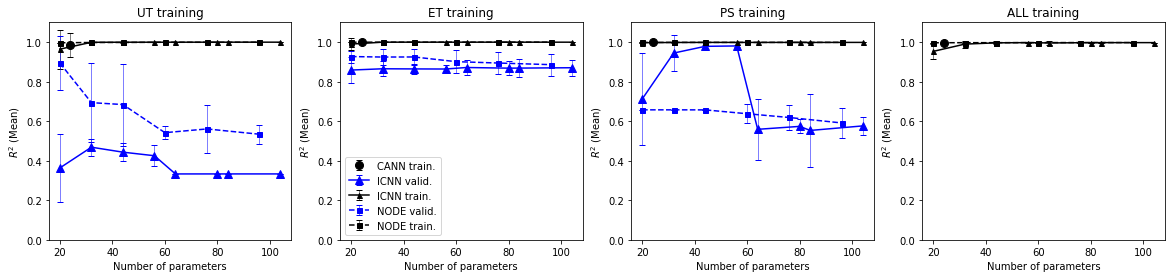

In [52]:
fig, axes = plt.subplots(1,4,figsize=(20,4))

loads = ['UT', 'ET', 'PS', 'ALL']
for i, (ax, load) in enumerate(zip(axes, loads)):
    models  = ['CANN',  'ICNN', 'NODE']
    markers = ['o',     '^-',   's--' ]
    for model, marker in zip(models, markers):
        with open('savednet/'+model+'_r2_efficiency_' + load + '.npy', 'rb') as f:
            np_list, r2 = pickle.load(f)
        
        if load=='ALL':
            other_id = None
        else:
            other_id = np.delete(np.array([0,1,2]), i)
        
        if model=='CANN':
            r2_mean = np.mean(r2,axis=0)
            r2_stdv = np.std(r2, axis=0)
            mean_trn = r2_mean[i]
            stdv_trn = r2_stdv[i]
            mean_val = np.mean(r2_mean[other_id])
            stdv_val = np.mean(r2_stdv[other_id])
            ms = 8
        else:
            r2_mean = np.mean(r2,axis=1)
            r2_stdv = np.std(r2, axis=1)
            mean_trn = r2_mean[:,i]
            stdv_trn = r2_stdv[:,i]
            if load == 'ALL':
                pass
            else:
                other_id = np.delete(np.array([0,1,2]), i)
                mean_val = np.mean(r2_mean, axis=1)
                stdv_val = np.mean(r2_stdv, axis=1)
                mean_val = np.squeeze(mean_val)
                stdv_val = np.squeeze(stdv_val)
                ax.errorbar(np_list, mean_val, stdv_val, elinewidth=0.5, capsize=3.0, fmt=marker, color='b', label=model + ' valid.', markersize=ms)
            ms = 5
        
        ax.errorbar(np_list, mean_trn, stdv_trn, elinewidth=0.5, capsize=3.0, fmt=marker, color='k', label=model + ' train.', markersize=ms)
    ax.set(ylim=[0,1.1], xlabel='Number of parameters', ylabel='$R^2$ (Mean)', title=load + ' training')
axes[1].legend()
fig.savefig('Figures/fig_rubber_efficiency_r2.jpg')

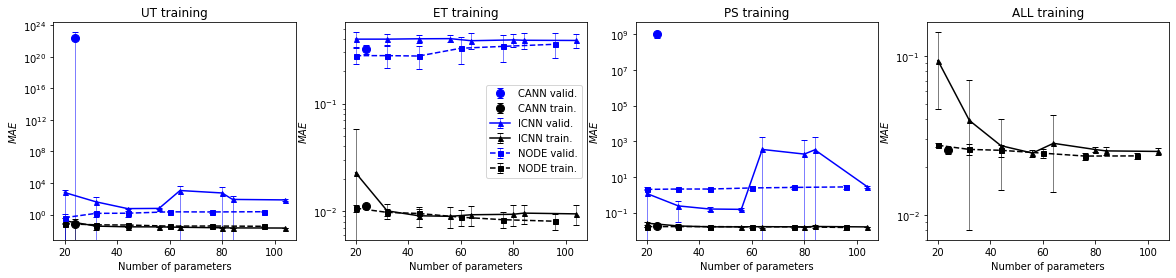

In [53]:
fig, axes = plt.subplots(1,4,figsize=(20,4))

loads = ['UT', 'ET', 'PS', 'ALL']
for i, (ax, load) in enumerate(zip(axes, loads)):
    models  = ['CANN',  'ICNN', 'NODE']
    markers = ['o',     '^-',   's--' ]
    for model, marker in zip(models, markers):
        with open('savednet/'+model+'_mae_efficiency_' + load + '.npy', 'rb') as f:
            np_list, mae = pickle.load(f)
        
        if load=='ALL':
            other_id = None
        else:
            other_id = np.delete(np.array([0,1,2]), i)
        
        if model=='CANN':
            mae_mean = np.mean(mae,axis=0)
            mae_stdv = np.std(mae, axis=0)
            mean_trn = mae_mean[i]
            stdv_trn = mae_stdv[i]
            ms = 8
            if load == 'ALL':
                pass
            else:
                mean_val = np.mean(mae_mean[other_id])
                stdv_val = np.mean(mae_stdv[other_id])
                ax.errorbar(np_list, mean_val, stdv_val, elinewidth=0.5, capsize=3.0, fmt=marker, color='b', label=model + ' valid.', markersize=ms)
        else:
            mae_mean = np.mean(mae,axis=1)
            mae_stdv = np.std(mae, axis=1)
            mean_trn = mae_mean[:,i]
            stdv_trn = mae_stdv[:,i]
            ms = 5
            if load == 'ALL':
                pass
            else:
                other_id = np.delete(np.array([0,1,2]), i)
                mean_val = np.mean(mae_mean[:,other_id], axis=1)
                stdv_val = np.mean(mae_stdv[:,other_id], axis=1)
                mean_val = np.squeeze(mean_val)
                stdv_val = np.squeeze(stdv_val)
                ax.errorbar(np_list, mean_val, stdv_val, elinewidth=0.5, capsize=3.0, fmt=marker, color='b', label=model + ' valid.', markersize=ms)

        
        ax.errorbar(np_list, mean_trn, stdv_trn, elinewidth=0.5, capsize=3.0, fmt=marker, color='k', label=model + ' train.', markersize=ms)
    ax.set(xlabel='Number of parameters', ylabel='$MAE$', title=load + ' training', yscale='log')
axes[1].legend()
fig.savefig('Figures/fig_rubber_efficiency_mae.jpg')

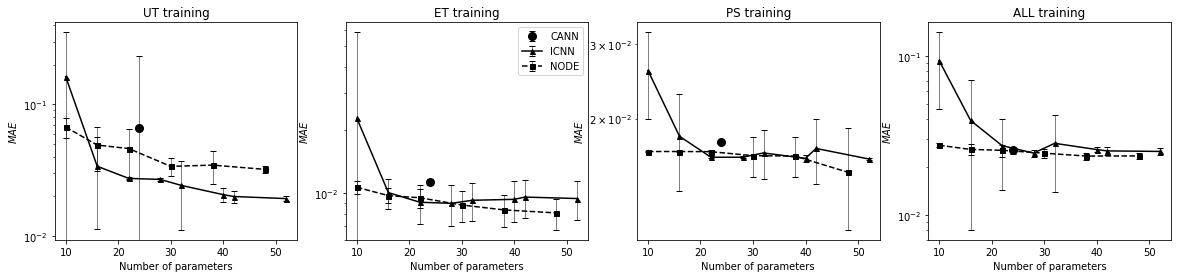

In [63]:
fig, axes = plt.subplots(1,4,figsize=(20,4))

loads = ['UT', 'ET', 'PS', 'ALL']
panels = ['a', 'b', 'c', 'd']
for i, (ax, load, panel) in enumerate(zip(axes, loads, panels)):
    models  = ['CANN',  'ICNN', 'NODE']
    markers = ['o',     '^-',   's--' ]
    for model, marker in zip(models, markers):
        with open('savednet/'+model+'_mae_efficiency_' + load + '.npy', 'rb') as f:
            np_list, mae = pickle.load(f)
        
        if load=='ALL':
            other_id = None
        else:
            other_id = np.delete(np.array([0,1,2]), i)
        
        if model=='CANN':
            mae_mean = np.mean(mae,axis=0)
            mae_stdv = np.std(mae, axis=0)
            mean_trn = mae_mean[i]
            stdv_trn = mae_stdv[i]
            ms = 8
        else:
            mae_mean = np.mean(mae,axis=1)
            mae_stdv = np.std(mae, axis=1)
            mean_trn = mae_mean[:,i]
            stdv_trn = mae_stdv[:,i]
            ms = 5
        
        ax.errorbar(np_list, mean_trn, stdv_trn, elinewidth=0.5, capsize=3.0, fmt=marker, color='k', label=model, markersize=ms)
        if mean_trn.shape == ():
            errorp = stdv_trn
            errorm = onp.min(onp.array([stdv_trn, mean_trn])) - 1.e-6 # this is to make sure the lower bound of the error bar is not negative in log plots
            data = onp.expand_dims(onp.array([onp.array(np_list).squeeze(), mean_trn, errorp, errorm]), axis=0)
        else:
            errorp = stdv_trn
            errorm = onp.min(onp.array([stdv_trn, mean_trn]), axis=0) - 1.e-6 # this is to make sure the lower bound of the error bar is not negative in log plots
            data = onp.array([onp.array(np_list).squeeze(), mean_trn, errorp, errorm]).T
        columns = ['x', 'y', 'error+', 'error-']
        df = pd.DataFrame(data, columns=columns)
        df.to_csv('TikZ/fig_rubber_eff_data/'+model+'_'+panel+'.csv', index=False, sep = ' ')
    ax.set(xlabel='Number of parameters', ylabel='$MAE$', title=load + ' training', yscale='log')
axes[1].legend()
fig.savefig('Figures/fig_rubber_efficiency_mae_trnonly.jpg')